<a href="https://colab.research.google.com/github/ddraedd/Decoding-Motor-Intention-from-Neural-Signals-Using-a-Simple-Neural-Network/blob/main/MT_S1_from_Processed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [23]:
# data downsampled to 10 ms bins
mat_file_path = "/content/drive/MyDrive/primate spike data/data_and_scripts/source_data/processed/MT_S1_processed.mat"
mat = scipy.io.loadmat(mat_file_path, squeeze_me=True, struct_as_record=False)
data = mat['Data']

In [26]:
kinematics = data.kinematics
reach_dirs = data.reach_dir
spikes_pmd = data.neural_data_PMd


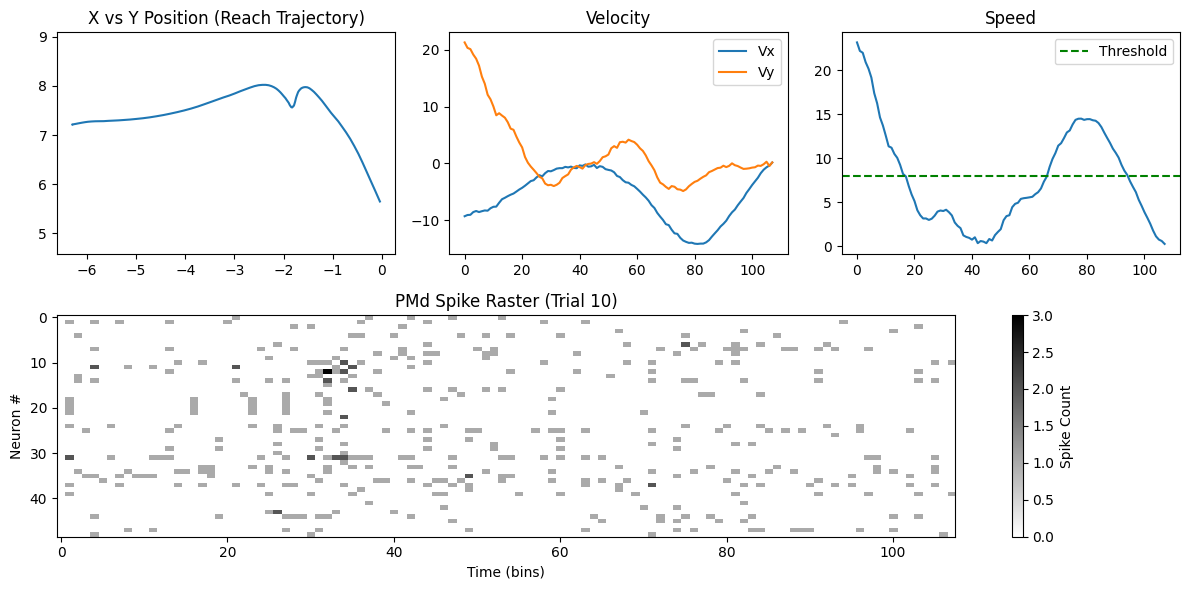

In [27]:
import matplotlib.pyplot as plt
import numpy as np

trial_id = 10  # pick a trial

# Kinematics: columns 1–2 = pos, 3–4 = vel, 5–6 = acc
kin = kinematics[trial_id]
x, y = kin[:, 0], kin[:, 1]
vx, vy = kin[:, 2], kin[:, 3]
speed = np.sqrt(vx**2 + vy**2)

# PMd spikes
pmd_spikes = spikes_pmd[trial_id]  # shape: (#neurons, #time_bins)

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(x, y)
plt.title("X vs Y Position (Reach Trajectory)")
plt.axis("equal")

plt.subplot(2, 3, 2)
plt.plot(vx, label='Vx')
plt.plot(vy, label='Vy')
plt.title("Velocity")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(speed)
plt.axhline(8, color='g', linestyle='--', label="Threshold")
plt.title("Speed")
plt.legend()

plt.subplot(2, 1, 2)
plt.imshow(pmd_spikes, aspect='auto', interpolation='nearest', cmap='gray_r')
plt.colorbar(label='Spike Count')
plt.title("PMd Spike Raster (Trial {})".format(trial_id))
plt.xlabel("Time (bins)")
plt.ylabel("Neuron #")

plt.tight_layout()
plt.show()


In [30]:
# to predict the direction of reach create a binary response variable (left vs right)
y = (np.array(reach_dirs) > 0).astype(int)
print(Counter(y))

Counter({np.int64(1): 214, np.int64(0): 205})


In [34]:
shapes = [trial.shape for trial in data.neural_data_PMd]
from collections import Counter
print(Counter(shapes))

Counter({(49, 111): 19, (49, 105): 13, (49, 117): 13, (49, 120): 11, (49, 122): 11, (49, 119): 10, (49, 113): 10, (49, 102): 10, (49, 116): 10, (49, 133): 9, (49, 123): 9, (49, 103): 9, (49, 106): 9, (49, 121): 9, (49, 125): 9, (49, 124): 9, (49, 92): 8, (49, 129): 8, (49, 109): 8, (49, 132): 8, (49, 104): 8, (49, 128): 8, (49, 126): 8, (49, 108): 7, (49, 115): 7, (49, 127): 7, (49, 98): 7, (49, 118): 7, (49, 110): 7, (49, 94): 7, (49, 112): 6, (49, 141): 6, (49, 114): 6, (49, 107): 6, (49, 93): 6, (49, 130): 6, (49, 134): 5, (49, 136): 5, (49, 100): 5, (49, 91): 4, (49, 162): 4, (49, 145): 4, (49, 90): 4, (49, 97): 4, (49, 148): 4, (49, 140): 4, (49, 96): 4, (49, 131): 4, (49, 135): 4, (49, 99): 4, (49, 89): 4, (49, 142): 3, (49, 137): 3, (49, 147): 3, (49, 139): 2, (49, 160): 2, (49, 101): 2, (49, 143): 2, (49, 86): 2, (49, 169): 2, (49, 150): 2, (49, 158): 2, (49, 138): 2, (49, 149): 2, (49, 144): 2, (49, 87): 2, (49, 170): 1, (49, 156): 1, (49, 163): 1, (49, 79): 1, (49, 76): 1, (4

In [35]:
# gather all the neural spike data as the predictor variable X
# most common (49, 111)
target_shape = (49, 111)
X = []
y = []

for i, trial in enumerate(spikes_pmd):
    if trial.shape == target_shape:
        X.append(trial.flatten())             # shape: 49*111 = 5439
        y.append(1 if reach_dirs[i] > 0 else 0)  # binary: right = 1, left = 0

X = np.vstack(X)
y = np.array(y)

print("X shape:", X.shape)
print("Class counts:", Counter(y))


X shape: (19, 5439)
Class counts: Counter({np.int64(1): 11, np.int64(0): 8})


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Data to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Model
model = SimpleNet(input_dim=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.6845
Epoch 5 | Loss: 0.0069
Epoch 10 | Loss: 0.0004
Epoch 15 | Loss: 0.0001
Epoch 20 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 35 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 45 | Loss: 0.0000


In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
with torch.no_grad():
    probs = model(X_test_t).numpy().squeeze()
    preds = (probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, preds))
print("AUC:", roc_auc_score(y_test, probs))


Accuracy: 1.0
AUC: 1.0


Model Evaluation

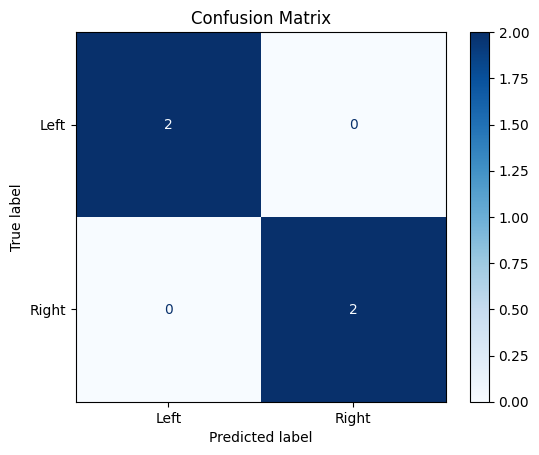

In [39]:
# Get predictions
model.eval()
with torch.no_grad():
    probs = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().squeeze()
    preds = (probs > 0.5).astype(int)

# Plot
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Left", "Right"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


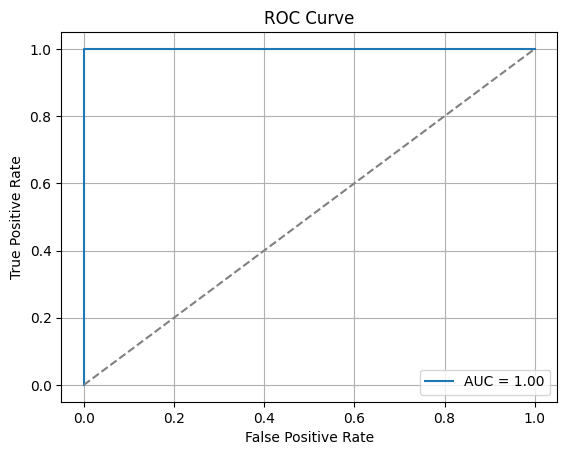

In [42]:
# Calculate ROC scurve
fpr, tpr, _ = roc_curve(y_test, probs)
auc_score = roc_auc_score(y_test, probs)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


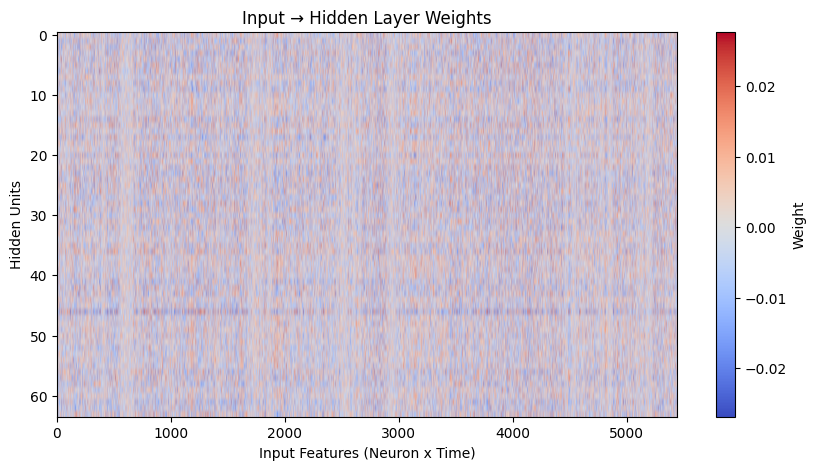

In [48]:
# For a PyTorch model with:
# model.model[0] = Linear(input_dim, hidden_dim)

weights = model.model[0].weight.detach().numpy()  # shape: (hidden_dim, input_dim)

plt.figure(figsize=(10, 5))
plt.imshow(weights, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Weight")
plt.title("Input → Hidden Layer Weights")
plt.xlabel("Input Features (Neuron x Time)")
plt.ylabel("Hidden Units")
plt.show()
